# Basal Ganglia on SpiNNaker and SpineML

This is a SpineML reproduction of Basab's SpiNNaker implementation of a GPR-like Basal Ganglia model. This notebook pertains to the single channel model only; there will be another notebook for the three channel model.

## Simple analysis from spikes

This is very simple spike counting code, useful for constant input, steady state network analysis.

In [1]:
import numpy as np
def firing_rate (logdir1, spikelogfile, numneurons, simlength_ms):
    # Read first lot of data
    logpath = logdir1 + spikelogfile
    spikelist = np.genfromtxt (logpath, delimiter=',')

    # Number of spikes total / number of neurons / time
    tspikes = len(spikelist[:,0])
    print ('Total spikes in {0} neurons in {1}: {2}'.format(numneurons, spikelogfile, tspikes))
    
    spnps = float(tspikes) / float(numneurons) / float(float(simlength_ms)/1000.0)
    print ('Mean spike rate: {0}'.format(spnps))
    

In [2]:
# D1 firing rate from the fully lesioned experiment. Experiment 1.
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e1/log/','D1_MSN_spike_log.csv', 1255, 6000)

Total spikes in 1255 neurons in D1_MSN_spike_log.csv: 3759
Mean spike rate: 0.499203187251


In [3]:
# D1 firing rate from the lesioned experiment with recurrent D1->D1 inhibition. Experiment 2.
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e2/log/','D1_MSN_spike_log.csv', 1255, 6000)

Total spikes in 1255 neurons in D1_MSN_spike_log.csv: 5708
Mean spike rate: 0.758034528552


In [5]:
# Firing rates in all populations, steady state experiment 0
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','D1_MSN_spike_log.csv', 1255, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','D2_MSN_spike_log.csv', 1255, 6000)
#firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','FSI_spike_log.csv', 84, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','STN_spike_log.csv', 14, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','GPe_spike_log.csv', 46, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','SNr_spike_log.csv', 27, 6000)

Total spikes in 1255 neurons in D1_MSN_spike_log.csv: 1014
Mean spike rate: 0.134661354582
Total spikes in 1255 neurons in D2_MSN_spike_log.csv: 14
Mean spike rate: 0.00185922974768
Total spikes in 14 neurons in STN_spike_log.csv: 266
Mean spike rate: 3.16666666667
Total spikes in 46 neurons in GPe_spike_log.csv: 1973
Mean spike rate: 7.14855072464
Total spikes in 27 neurons in SNr_spike_log.csv: 3862
Mean spike rate: 23.8395061728


## Firing rate analysis from voltage output
I copied this code from the GPR Izhikevich project. I've not tested it yet (20170621).

In [37]:
def population_spiking (population_name, spike_thresh, start_ms, end_ms):

    # Make sure we have access to the load_sc_data and firing_rate functions
    import load_sc_data as lsd
    import firing_rate as fr

    # Load data from SpineML_2_BRAHMS
    filepath = '/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/'+population_name+'_v_log.bin';
    print filepath
    V, count, t, nn, dt = lsd.load_sc_data(filepath)

    print ('{0} has {1} neurons'.format(population_name, nn))
    rates = []
    ratetot = 0
    numanalysed = 0
    # Analyse with firing_rate.pyc
    for i in range (0,nn,6):
        rate, isiRate = fr.firing_rate2(V[i],(end_ms-start_ms),dt,spike_thresh,start_ms)
        rates.append(rate)
        ratetot = ratetot + rate;
        numanalysed = numanalysed + 1
        print ('Spiking rate for {0} neuron {1}:{2} spikes/s'.format(population_name,i,rate))
    print '--\n',population_name,'mean rate: ', float(ratetot)/numanalysed,'spikes/s'

In [ ]:
population_spiking ('D1_MSN',-15,200,800)
population_spiking ('D2_MSN',-15,200,800)
population_spiking ('STN',-15,200,800)
population_spiking ('GPe',-15,200,800)
population_spiking ('SNr',-15,200,800)

## Histogram firing rate analysis from spike logs
The following code block defines some functions to visualise the firing rates from running the model. This was taken from my other Izhikevich BG model and so will need some re-writing.

This will be useful for analysing selection experiments when we get to that point.

Basab's model has 14 STN neurons 1255 D1s, 1255 D2s, 84 FSIs, 27 SNr neurons and 46 GPe neurons.

In [75]:
# A global parameter for the length of the sim.
simlength = 6000

In [40]:
# Visualisation of mean firing rates from bg1 simulation, with and without sigmoid.
import numpy as np

# Graph the data. Sub-called by vis_data
def graph_data (bin_edges, fr, logfile):
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,8))
    #plt.clf;

    plt.plot (bin_edges[0:-1],fr, '--', color='r', marker='o', label='Channel 1', linewidth=3)

    plt.legend(loc='best',fontsize=14)

    plt.xlabel('t (ms)',fontsize=24);
    
    from matplotlib import rc
    plt.ylabel('mean neuronal firing rate (s$^{-1}$)',fontsize=24);
    plt.tick_params(axis='x', labelsize=24, pad=10)
    plt.tick_params(axis='y', labelsize=24, pad=10)
    
    plt.title(logfile)

    graphdir = '/home/seb/models/GPR-BSB/labbook/'

    filename = logfile.replace(' ','_')
    plt.savefig('{0}{1}.svg'.format(graphdir, filename))
    
    plt.show()
    
# Read & precompute the data. Sub-called by vis_data and compute_decision
def compute_data (logdir1, logfile, numneurons, simlength_ms):
    # Read first lot of data
    logpath = logdir1 + logfile
    spikelist = np.genfromtxt (logpath, delimiter=',')
    
    # Give our histograms 20 bins.
    numbins = 40

    ch1fr, bin_edges1 = np.histogram (spikelist[:,0], numbins)

    # There are 20 neurons per channel in this model, 60 total
    num_channels_used = 1
    neuronsPerInvestigation = numneurons * num_channels_used
    
    # Scale the firing rates
    bintime = simlength_ms / numbins;
    fr  = (ch1fr) * 1000 / (bintime * numneurons)

    return bin_edges1, fr
    
# Visualise the given logfile (the log of a single population) 
def vis_data (logdir1, logfile, numneurons, simlength_ms):
    bin_edges, fr = compute_data (logdir1, logfile, numneurons, simlength_ms)
    graph_data (bin_edges, fr, logfile)

## end visualisation functions


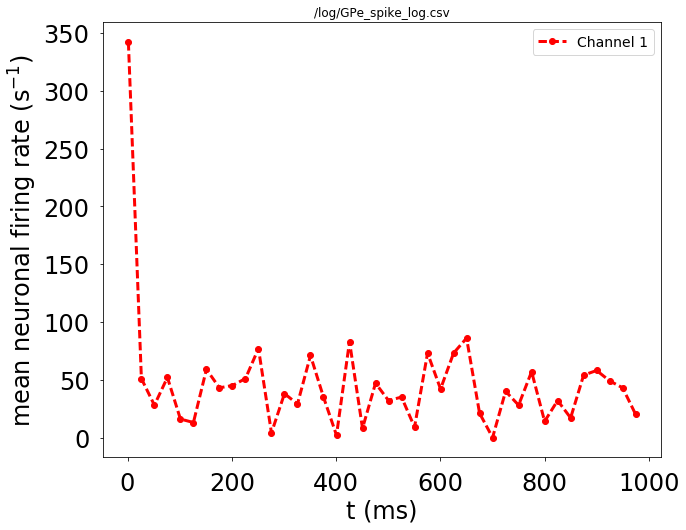

In [23]:
# GPe population
vis_data('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0','/log/GPe_spike_log.csv', 46, simlength)

In [ ]:
# STN population
vis_data('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0','/log/STN_spike_log.csv', 14, simlength)

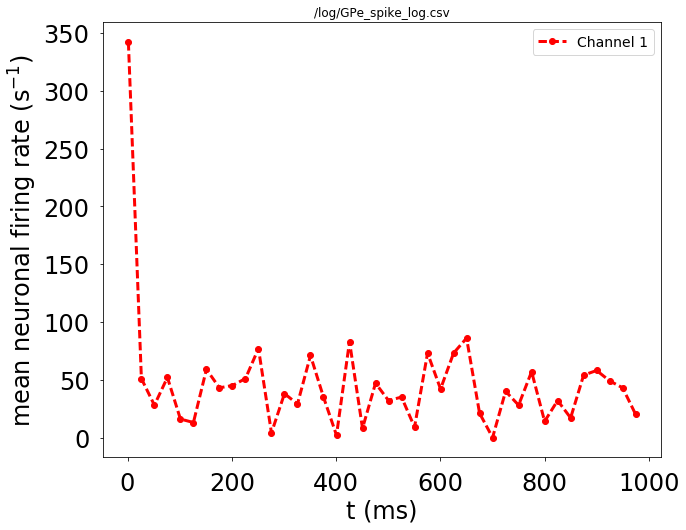

In [27]:
# GPe population
vis_data('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0','/log/GPe_spike_log.csv', 46, simlength)

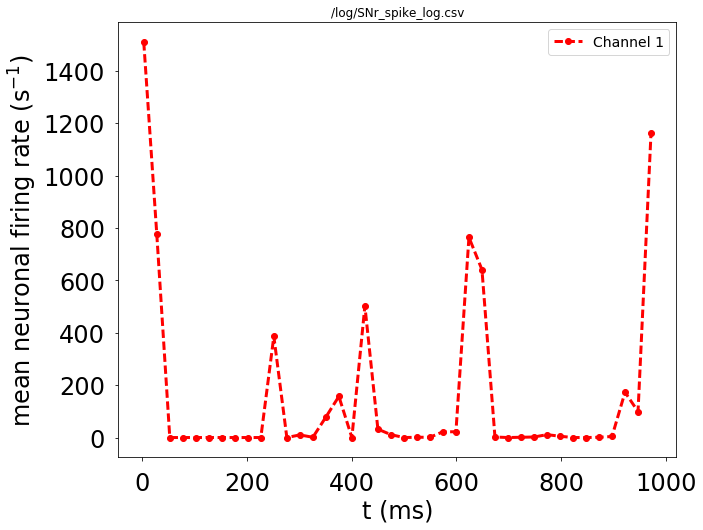

In [28]:
# SNr population
vis_data('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0','/log/SNr_spike_log.csv', 27, simlength)